In [1]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
credentials_file = os.path.abspath(os.path.join('..', 'credentials.yaml'))
with open(credentials_file, 'r') as f:
    credentials = yaml.safe_load(f)

storage_options = {
    'key': credentials['aws']['access_key'],
    'secret': credentials['aws']['secret_access_key']
}

In [49]:
metadata_uri = f's3://{credentials["aws"]["bucket"]}/metadata/metadata_preprocessed.json'
metadata = pd.read_json(metadata_uri, storage_options=storage_options, orient='index')
metadata.head()

,metadata_collected_flg,reviews_collected_flg,original_title,director,poster_url,actors,imdb_recommendations,rating,num_votes,user_review_num,...,original_language,production_company_1,production_company_2,production_company_3,filming_location,filming_country,budget,boxoffice_gross_domestic,boxoffice_gross_opening,boxoffice_gross_worldwide
/title/tt1806913/,True,True,Golmaal Again,Rohit Shetty,https://m.media-amazon.com/images/M/MV5BYmI5Y2...,"{'1': '/name/nm0222426/', '2': '/name/nm045117...","{'1': '/title/tt1562859/', '2': '/title/tt1092...",4.9,9600,79.0,...,Hindi,Mangal Murti Films,Reliance Entertainment,Rohit Shetty Picturez,"Gstaad, Kanton Bern, Switzerland",Switzerland,None,"$1,013,893","$1,013,893","$2,058,098"
/title/tt0367959/,True,True,Hannibal Rising,Peter Webber,https://m.media-amazon.com/images/M/MV5BMTIzMT...,"{'1': '/name/nm0880484/', '2': '/name/nm040697...","{'1': '/title/tt0212985/', '2': '/title/tt0289...",6.1,111000,454.0,...,English,Dino De Laurentiis Company,Quinta Communications,Ingenious Film Partners,Lithuania,Lithuania,"$50,000,000 (estimated)","$27,670,986","$13,051,650","$82,169,884"
/title/tt0445054/,True,True,7 Days,Daniel Grou,https://m.media-amazon.com/images/M/MV5BYmNkMW...,"{'1': '/name/nm0499218/', '2': '/name/nm032072...","{'1': '/title/tt1331291/', '2': '/title/tt1555...",6.5,8100,57.0,...,French,Go Films,None,None,"Québec, Canada",Canada,"CA$3,400,000 (estimated)",None,None,"$1,259"
/title/tt0364517/,True,True,Love Me If You Dare,Yann Samuell,https://m.media-amazon.com/images/M/MV5BZjZhYm...,"{'1': '/name/nm0133899/', '2': '/name/nm018283...","{'1': '/title/tt1440232/', '2': '/title/tt0372...",7.5,70000,117.0,...,French,Nord-Ouest Films,StudioCanal,Artémis Productions,"Liège, Wallonia, Belgium",Belgium,None,"$553,504","$21,546","$8,604,201"
/title/tt0961097/,True,True,A Monster in Paris,Bibo Bergeron,https://m.media-amazon.com/images/M/MV5BMWY2Mz...,"{'1': '/name/nm1342060/', '2': '/name/nm066085...","{'1': '/title/tt0944834/', '2': '/title/tt1181...",6.7,21000,61.0,...,French,EuropaCorp,Bibo Films,France 3 Cinéma,None,None,"€25,000,000 (estimated)",None,None,"$26,710,392"


In [56]:
metadata.columns

Index(['metadata_collected_flg', 'reviews_collected_flg', 'original_title',
       'director', 'poster_url', 'actors', 'imdb_recommendations', 'rating',
       'num_votes', 'user_review_num', 'critic_review_num', 'metascore',
       'genre_1', 'genre_2', 'genre_3', 'release_date', 'also_known_as',
       'runtime', 'country_of_origin_1', 'country_of_origin_2',
       'country_of_origin_3', 'original_language', 'production_company_1',
       'production_company_2', 'production_company_3', 'filming_location',
       'filming_country', 'budget', 'boxoffice_gross_domestic',
       'boxoffice_gross_opening', 'boxoffice_gross_worldwide'],
      dtype='object')

In [4]:
partition_uri = f's3://{credentials["aws"]["bucket"]}/reviews/reviews_partition_1.csv'
partition = pd.read_csv(partition_uri, compression='gzip', storage_options=storage_options)
mem = partition.memory_usage(deep=True).sum()/1024/1024
print('Number of reviews:', len(partition))
print(f'Memory usage: {mem:.1f} Mb')
partition.head()

Number of reviews: 242940
Memory usage: 350.4


,text,rating,title,author,movie_id,upvotes,total_votes,review_date
0,"Chucky (the murderous doll from ""Child's Play""...",9.0,Silly but fun,/user/ur0463200/,/title/tt0144120/,33,40,2006-07-06
1,"They obviously made ""Bride of Chucky"" with the...",10.0,glass ceiling has a new meaning,/user/ur4888011/,/title/tt0144120/,17,20,2009-03-21
2,Well my opinion has changed for this one becau...,10.0,Who The (Beep) Is Martha Stewart?(**** Out Of...,/user/ur25851619/,/title/tt0144120/,19,22,2012-12-13
3,Clever is the word that comes to mind when I t...,6.0,A rough ride to Hackensack for Chucky and his...,/user/ur1048771/,/title/tt0144120/,11,15,2008-10-29
4,Realizing he needs to turn back into human for...,10.0,The best of the series,/user/ur25837689/,/title/tt0144120/,11,15,2012-08-23


In [60]:
partition = pd.merge(
    partition,
    metadata[['genre_1', 'genre_2', 'runtime', 'director']].reset_index(),
    left_on='movie_id',
    right_on='index'
)
partition.columns

Index(['text', 'rating', 'title', 'author', 'movie_id', 'upvotes',
       'total_votes', 'review_date', 'index', 'genre_1', 'genre_2', 'runtime',
       'director'],
      dtype='object')

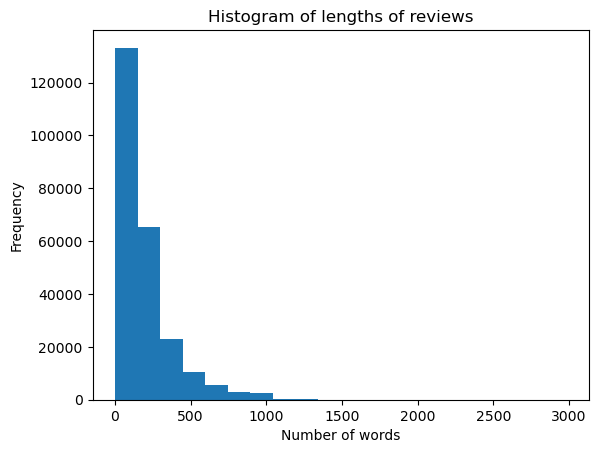

In [61]:
review_len = partition['text'].str.split().apply(len)
review_len.plot.hist(bins=20, title='Histogram of lengths of reviews')
plt.xlabel('Number of words')
plt.show()

In [74]:
top_n_in_genre

,genre_1,text
0,Action,"I've liked Brie Larson in other films, but she..."
1,Action,"I was left with the general feeling, that ""Cap..."
2,Action,"I live in Indonesia, and I've just seen it sin..."
3,Action,This is easily among the worst movies I have s...
4,Action,Finished watching the film about an hour ago a...
...,...,...
80846,Western,Many RKO make-overs and acting classes away fr...
80847,Western,The Outlaw is famous for introducing Jane Russ...
80848,Western,"In 1881 New Mexico, newly-appointed Sheriff Pa..."
80849,Western,"Okay look, I can deal with stereotyped gender ..."


In [79]:
top_n = 10000
top_n_in_genre = (
    partition
    .groupby('genre_1')
    .apply(lambda x: x.nlargest(top_n, 'total_votes'))
    ['text']
    .reset_index()
    .drop('level_1', axis=1)
)
genres = top_n_in_genre['genre_1'].unique()
top_n_in_genre_corpus = {
    g: " ".join(t for t in top_n_in_genre.query(f'genre_1 == "{g}"').text)
    for g in genres
}
# for genre in genres:
#     top_n_in_genre_corpus

In [ ]:
top_n_in_genre.query(f'genre_1 == ').text

In [81]:
top_n_in_genre_corpus['Action'][:1000]

'I\'ve liked Brie Larson in other films, but she showed ZERO range in this. When your main character in a superhero movie is unwatchable, you already have a problem. In addition, Captain Marvel has no weaknesses, which kills the tension immediately. There is no point at which you feel she is in any danger of losing, or any danger at all for that matter.It\'s an OK origin story, but it makes no sense as to WHY she\'s supposedly so powerful.The cat was good. I was left with the general feeling, that "Captain Marvel" is a major disappointment.First of all, there is a good story here somewhere, but it\'s just not well told, and there\'s too much of it crammed within about 115 minutes. The movie is fast-paced, but never really works, because the pacing is flat and timing is off. Aesthetically, "Captain Marvel" has been processed through the same "Marvel filter" as the rest of them. Dull. The filmmakers (indie directors of the great "Half Nelson") have given absolutely no attention to the mu

In [62]:
partition_sample = .head()

,text,rating,title,author,movie_id,upvotes,total_votes,review_date,index,genre_1,genre_2,runtime,director
0,"Chucky (the murderous doll from ""Child's Play""...",9.0,Silly but fun,/user/ur0463200/,/title/tt0144120/,33,40,2006-07-06,/title/tt0144120/,Comedy,Horror,89,Ronny Yu
1,"They obviously made ""Bride of Chucky"" with the...",10.0,glass ceiling has a new meaning,/user/ur4888011/,/title/tt0144120/,17,20,2009-03-21,/title/tt0144120/,Comedy,Horror,89,Ronny Yu
2,Well my opinion has changed for this one becau...,10.0,Who The (Beep) Is Martha Stewart?(**** Out Of...,/user/ur25851619/,/title/tt0144120/,19,22,2012-12-13,/title/tt0144120/,Comedy,Horror,89,Ronny Yu
3,Clever is the word that comes to mind when I t...,6.0,A rough ride to Hackensack for Chucky and his...,/user/ur1048771/,/title/tt0144120/,11,15,2008-10-29,/title/tt0144120/,Comedy,Horror,89,Ronny Yu
4,Realizing he needs to turn back into human for...,10.0,The best of the series,/user/ur25837689/,/title/tt0144120/,11,15,2012-08-23,/title/tt0144120/,Comedy,Horror,89,Ronny Yu
